Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON'],
      dtype='object')
         DR_NO               Date Rptd                DATE OCC  TIME OCC  \
0    200104875  01/12/2020 12:00:00 AM  01/12/2020 12:00:00 AM      1955   
1    200816285  11/11/2020 12:00:00 AM  11/10/2020 12:00:00 AM      1700   
2    200304982  01/17/2020 12:00:00 AM  01/17/2020 12:00:00 AM      1825   
3    200504796  01/19/2020 12:00:00 AM  01/19/2020 12:00:00 AM      1800   
4    200316294  08/25/2020 12:00:00 AM  08/25/2020 12:00:00 AM       700   
..         ...                     ...                     ...       ...   
994  230616403  10/12/2023 12:00:00 AM  10/11/2023 12:00:

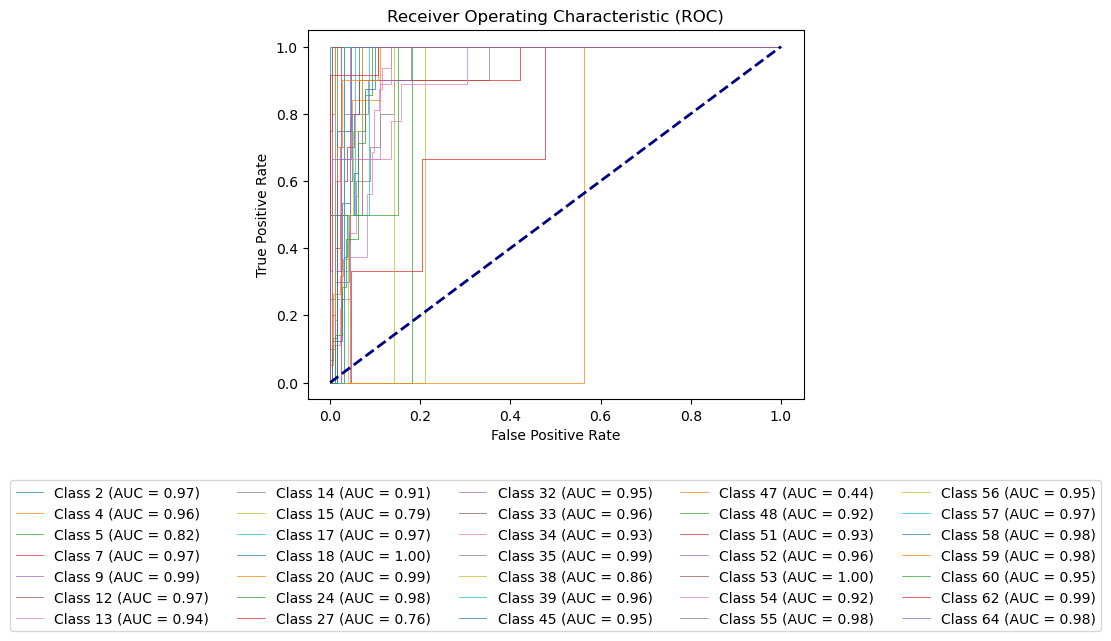

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
import numpy as np

# GitHub CSV URL
github_csv_url = "https://github.com/dmacia49/LA-Crime-Weather-Prediction/raw/dmacias/random_sampled_data.csv"

# Read data from GitHub CSV
crime_df = pd.read_csv(github_csv_url)

# Display columns and dataframe
print(crime_df.columns)
print(crime_df)

# Set label column
label_column = 'Crm Cd Desc'

# Columns to be treated as non-numeric
non_numeric_columns = ['DATE OCC', 'Date Rptd', 'Mocodes', 'Vict Sex', 'Vict Descent', 'Premis Desc', 'Weapon Desc', 'Status Desc', 'LOCATION', 'Cross Street']

# Drop non-numeric columns and convert to numeric, fill NaN with 0
X = crime_df.drop(columns=[label_column] + non_numeric_columns)
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Target variable
y = crime_df[label_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Display the head of the scaled features dataframe
scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
print(scaled_df.head())

# Logistic Regression Model
logreg_model = LogisticRegression(random_state=3, max_iter=1000)
logreg_model.fit(X_train_scaled, y_train)

# Predictions on the test set
y_pred = logreg_model.predict(X_test_scaled)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# One-vs-Rest Logistic Regression Model for Multiclass Classification
logreg_model = OneVsRestClassifier(LogisticRegression(random_state=3))
logreg_model.fit(X_train_scaled, y_train)

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=logreg_model.classes_)

# Predict probabilities for each class
y_prob = logreg_model.predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class...
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(logreg_model.classes_)):
    if np.sum(y_test_bin[:, i]) > 0:
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        # Plot ROC curve for each class
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})', linestyle='-', linewidth=0.5)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')

# Adjust the legend position to be below the graph
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, ncol=5)

plt.show()